Copyright 2018 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

> https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Datathon Tutorial

Welcome to the MIMIC/eICU/ANZICS Datathon! This [Colab](https://colab.research.google.com)-based tutorial will guide you through the working environment for accessing the dataset and get you familiarized with analyzing demo medical data in Google Cloud.

## Initial Setup
Here are the prerequisites for running all examples in this tutorial

* You MUST visit https://mimic.physionet.org/gettingstarted/demo/ and accept the terms and conditions for using MIMIC-III demo data to run the queries in this tutorial.
* You should already have had a valid Gmail account registered with the datathon organizers, and have been assigned a team.
  * If you do not have a Gmail account, you can create one at http://www.gmail.com. You need to notify [datathon organizers](mailto:sydney-datathon-2018-organizers@googlegroups.com) to register your new account for data access.
  * If you are not taking part in a MIMIC datathon, but do have MIMIC-III demo data access already, you may request to join [this Google Group](https://groups.google.com/forum/#!forum/mimic-demo-users) to run queries in this Colab notebook.
* To be able to run the queries in this tutorial, you need to create a copy of this Colab notebook by clicking "File" -> "Save a copy in Drive..." menu.
  * You can share your copy with your teammates by clicking on the "SHARE" button on the top-right corner of your Colab notebook copy. Everyone with "Edit" permission is able to modify the notebook at the same time, so it is a great way for team collaboration.

Now that you have done the initial setup, let us start playing with the data. First, you need to run some initialization code. You can run the following cell by clicking on the triangle button when you hover over the `[ ]` space on the top-left corner of the code cell below.

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import tensorflow as tf

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

Before running any queries using BigQuery, you need to first authenticate yourself by running the following cell. If you are running it for the first time, it will ask you to follow a link to log in using your Gmail account, and accept the data access requests to your profile. Once this is done, it will generate a string of verification code, which you should paste back to the cell below and press enter.

In [0]:
auth.authenticate_user()

## Querying the MIMIC-III Demo Dataset

Now we are ready to actually start following the "Cohort Selection" exercise adapted from the [MIMIC cohort selection tutorial on GitHub](https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/cohort-selection.ipynb). Because all datasets related to this Datathon are hosted on Google Cloud, there is no need to set up a local database or bring up a local Jupyter instance. Instead, we only need to connect to a BigQuery client with the desired Google Cloud project. The MIMIC-III demo data is hosted on the "`datathon-datasets`" project. Let's see what datasets are available in this project. For more information about BigQuery's `Client` object (and much more), please refer to [BigQuery Documentation](https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/usage.html).

In [4]:
project_id='datathon-datasets'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

client = bigquery.Client(project=project_id)
datasets = client.list_datasets()
for dataset in datasets:
  did = dataset.dataset_id
  print('Dataset "%s" has the following tables:' % did)
  for table in client.list_tables(client.dataset(did)):
    print('    ' + table.table_id)

Dataset "anzics" has the following tables:
Dataset "anzics_demo" has the following tables:
Dataset "eicu" has the following tables:
    admissionDx
    admissiondrug
    allergy
    apachePatientResult
    carePlanCareProvider
    carePlanEOL
    carePlanGeneral
    carePlanGoal
    carePlanInfectiousDisease
    diagnosis
    hospital
    lab
    medication
    pastHistory
    patient
    treatment
    vitalAperiodic
    vitalPeriodic
Dataset "mimic" has the following tables:
    admissions
    callout
    caregivers
    chartevents
    cptevents
    d_cpt
    d_icd_diagnoses
    d_icd_procedures
    d_items
    d_labitems
    datetimeevents
    diagnoses_icd
    drgcodes
    icustays
    inputevents_cv
    inputevents_mv
    labevents
    microbiologyevents
    outputevents
    patients
    prescriptions
    procedureevents_mv
    procedures_icd
    services
    transfers
Dataset "mimic_demo" has the following tables:
    admissions
    callout
    caregivers
    cptevents
    d_cpt
 

Another way to list all BigQuery tables in a Google Cloud Project is to go to the BigQuery site directly, e.g. https://bigquery.cloud.google.com/welcome/datathon-datasets. On the left panel, you will see the `mimic_demo` dataset, under which you will see the table names as above once you click and expand on the link.

To view the details of a table, simply click on it (for example the `icustays` table). Then, on the right side of the window, you will have to option to see the [schema](https://bigquery.cloud.google.com/table/datathon-datasets:mimic_demo.icustays?tab=schema), [metadata](https://bigquery.cloud.google.com/table/datathon-datasets:mimic_demo.icustays?tab=details) and [preview of rows](https://bigquery.cloud.google.com/table/datathon-datasets:mimic_demo.icustays?tab=preview) tabs.

Let's now run some queries adapted from [the MIMIC cohort selection tutorial](https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/cohort-selection.ipynb).
First, let's preview the `subject_id`, `hadm_id`, and `icustay_id` columns of the `icustays` table.

In [5]:
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})


run_query('''
SELECT
  subject_id,
  hadm_id,
  icustay_id
FROM
  mimic_demo.icustays
LIMIT 10
''')

,subject_id,hadm_id,icustay_id
0,40124,146893,269173
1,40503,168803,293429
2,10124,170883,295043
3,43827,149950,243238
4,42075,151323,298685
5,41976,125013,213315
6,10088,168233,249695
7,40601,182879,279529
8,44083,131048,282640
9,44222,192189,238186


The `LIMIT 10` clause in the query is handy for limiting the size of the output frame during query writing for easier viewing, and we can drop this clause once the query is finalized to run over the whole dataset. One thing to note is that even with the `LIMIT` clause, [running a query may still incur a cost, up to the full query without `LIMIT`](https://cloud.google.com/bigquery/docs/best-practices-costs#preview-data), so the best way to preview data in a table is the [preview tab](https://bigquery.cloud.google.com/table/datathon-datasets:mimic_demo.icustays?tab=preview) in the BigQuery interface. Please rest assured though that Google is sponsoring this Datathon event, so there will not be any cost for running queries in the provided Datathon projects during the event.

Now, let us try some Google SQL functions. Please consult the reference page at https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators for all available functions and operators. Here is an example how `TIMESTAMP_DIFF` can be used for finding how many hours patients ICU stay lasted. Notice how the query result is stored and used in a pandas dataframe.

In [6]:
df = run_query('''
SELECT
  subject_id,
  hadm_id,
  icustay_id,
  intime,
  outtime,
  TIMESTAMP_DIFF(outtime, intime, HOUR) as icu_stay_hours
FROM mimic_demo.icustays
LIMIT 10
''')
df.head()

,subject_id,hadm_id,icustay_id,intime,outtime,icu_stay_hours
0,40124,146893,269173,2130-08-12 05:50:38,2130-08-15 23:53:00,90
1,40503,168803,293429,2186-07-06 19:59:36,2186-07-07 20:48:07,24
2,10124,170883,295043,2192-04-24 02:29:49,2192-04-26 23:59:45,69
3,43827,149950,243238,2176-07-14 13:25:36,2176-07-16 23:06:00,57
4,42075,151323,298685,2166-02-12 17:57:37,2166-02-26 02:31:45,320


Here is the BigQuery query to list some patients whose ICU stay is at least 2 days. Note that you can use `AS` in the `SELECT` clause to rename a field in the output, and you can omit the table prefix if there is no ambiguity.

In [7]:
run_query('''
WITH co AS (
  SELECT
    subject_id,
    hadm_id,
    icustay_id,
    TIMESTAMP_DIFF(outtime, intime, DAY) AS icu_length_of_stay
  FROM mimic_demo.icustays
  LIMIT 10)
SELECT
  subject_id,
  co.hadm_id AS hadm_ID,
  co.icustay_id,
  co.icu_length_of_stay
FROM co
WHERE icu_length_of_stay >= 2
''')

,subject_id,hadm_ID,icustay_id,icu_length_of_stay
0,10124,170883,295043,2
1,43827,149950,243238,2
2,41976,125013,213315,2
3,40601,182879,279529,2
4,44083,131048,282640,2
5,40124,146893,269173,3
6,42075,151323,298685,13


Now, instead of filtering out ICU stays of length 1 day or less, let's label all the ICU stays with an integer, either 1 for stays of length 2 days or more, or 0 for stays shorter than 2 days. The resulting table is called a "cohort table" in the [original MIMIC-III tutorial](https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/cohort-selection.ipynb).

In [8]:
run_query('''
WITH co AS (
  SELECT
    subject_id,
    hadm_id,
    icustay_id,
    TIMESTAMP_DIFF(outtime, intime, DAY) AS icu_length_of_stay
  FROM mimic_demo.icustays
  LIMIT 10)
SELECT
  subject_id,
  hadm_id,
  icustay_id,
  icu_length_of_stay,
  IF(icu_length_of_stay < 2, 1, 0) AS exclusion_los
FROM co
ORDER BY icustay_id''')


,subject_id,hadm_id,icustay_id,icu_length_of_stay,exclusion_los
0,41976,125013,213315,2,0
1,44222,192189,238186,1,1
2,43827,149950,243238,2,0
3,10088,168233,249695,1,1
4,40124,146893,269173,3,0
5,40601,182879,279529,2,0
6,44083,131048,282640,2,0
7,40503,168803,293429,1,1
8,10124,170883,295043,2,0
9,42075,151323,298685,13,0


Let's now try a query that requires table joining: include the patient's age at the time of ICU admittance. This is computed by the date difference in years between the ICU `intime` and the patient's date of birth. The former is available in the `icustays` table, and the latter resides in the `dob` column of the `patients` table.

In [9]:
run_query('''
WITH co AS (
  SELECT
    icu.subject_id,
    icu.hadm_id,
    icu.icustay_id,
    pat.dob,
    TIMESTAMP_DIFF(icu.outtime, icu.intime, DAY) AS icu_length_of_stay,
    DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age
  FROM mimic_demo.icustays AS icu
  INNER JOIN mimic_demo.patients AS pat
    ON icu.subject_id = pat.subject_id
  LIMIT 10)
SELECT
  subject_id,
  hadm_id,
  icustay_id,
  icu_length_of_stay, co.age,
  IF(icu_length_of_stay < 2, 1, 0) AS exclusion_los
FROM co
''')


,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,exclusion_los
0,40503,168803,293429,1,89,1
1,10088,168233,249695,1,78,1
2,44222,192189,238186,1,73,1
3,10124,170883,295043,2,84,0
4,43827,149950,243238,2,300,0
5,41976,125013,213315,2,65,0
6,40601,182879,279529,2,72,0
7,44083,131048,282640,2,55,0
8,40124,146893,269173,3,67,0
9,42075,151323,298685,13,80,0


It is somewhat surprising to see a patient whose age is 300! This raises the question whether the age distribution of all patients is sane. We can verify this by querying the quantiles of patients' ages. Notice that we have removed the `LIMIT 10` clause in the inner query, but the result is only one row, containing an array of 11 ingeter ages.

In [11]:
run_query('''
WITH co AS (
  SELECT
    DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age
  FROM mimic_demo.icustays AS icu
  INNER JOIN mimic_demo.patients AS pat
    ON icu.subject_id = pat.subject_id)
SELECT
  APPROX_QUANTILES(age, 10) AS age_quantiles
FROM co
''')

,age_quantiles
0,"[17, 49, 62, 65, 69, 74, 78, 82, 86, 88, 300]"


The result says that the minimum age (0th percentile) is 17, the 10th percentile is 49, the 20th percentile is 62, and so on, and 300 is the maximum (100-th percentile). The distribution looks good, and 300 could be an outlier caused by inaccurate data collection.

In [12]:
run_query('''
SELECT
  DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age
FROM mimic_demo.icustays AS icu
INNER JOIN mimic_demo.patients AS pat
  ON icu.subject_id = pat.subject_id
ORDER BY age DESC
LIMIT 10
''')


,age
0,300
1,300
2,300
3,300
4,300
5,300
6,300
7,300
8,300
9,89


Indeed, there are 9 cases of 300-year olds patient ICU admittances that look suspicious, but after that, the maximum age of the patients is 89. Actually, the 300 age is intentionally introduced in the MIMIC-III datasets for privacy protection of patients whose age is 90 or beyond: any patient in this age group got their age redacted to 300.

Next, let's see how many ICU admissions each patient had.

In [13]:
run_query('''
WITH co AS (
  SELECT
    icu.subject_id,
    icu.hadm_id,
    icu.icustay_id,
    pat.dob,
    TIMESTAMP_DIFF(icu.outtime, icu.intime, DAY) AS icu_length_of_stay,
    DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age,
    RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
  FROM mimic_demo.icustays AS icu
  INNER JOIN mimic_demo.patients AS pat
    ON icu.subject_id = pat.subject_id
  ORDER BY hadm_id DESC
  LIMIT 10
  )
SELECT
  subject_id,
  hadm_id,
  icustay_id,
  icu_length_of_stay, co.age,
  IF(icu_length_of_stay < 2, 1, 0) AS exclusion_los,
  icustay_id_order
FROM co
ORDER BY subject_id, icustay_id_order
''')


,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,exclusion_los,icustay_id_order
0,10017,199207,204881,2,74,0,1
1,10027,199395,286020,7,82,0,1
2,10076,198503,201006,7,69,0,1
3,10120,193924,268282,2,27,0,1
4,10132,197611,292910,0,65,1,1
5,40177,198480,236120,1,87,1,1
6,40177,198480,285750,0,87,1,2
7,42281,195911,256746,3,68,0,1
8,42281,195911,221684,15,68,0,2
9,44083,198330,286428,3,55,0,3


In the last column, we see that for some patients (e.g. Subject `40177` and `42281`), there are multiple ICU stays. In research studies, we usually filter out follow-up ICU stays, and only keep the first ICU stay so as to minimize unwanted data correlation. For this purpose, we create an exclusion label column based on icustay_id_order, which becomes handy for filtering needs. This is done by ranking the ICU visits ordered by the admission time in the following query, and `PARTITION BY` ensures that the ranking is within each patient (`subject_id`).

In [14]:
run_query('''
WITH co AS (
  SELECT
    icu.subject_id,
    icu.hadm_id,
    icu.icustay_id,
    pat.dob,
    TIMESTAMP_DIFF(icu.outtime, icu.intime, DAY) AS icu_length_of_stay,
    DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age,
    RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
  FROM mimic_demo.icustays AS icu
  INNER JOIN mimic_demo.patients AS pat
    ON icu.subject_id = pat.subject_id
  ORDER BY hadm_id DESC
  LIMIT 10
  )
SELECT
  subject_id,
  hadm_id,
  icustay_id,
  icu_length_of_stay, co.age,
  IF(icu_length_of_stay < 2, 1, 0) AS exclusion_los,
  icustay_id_order,
  IF(icustay_id_order = 1, 0, 1) AS exclusion_first_stay
FROM co
ORDER BY subject_id, icustay_id_order
''')


,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,exclusion_los,icustay_id_order,exclusion_first_stay
0,10017,199207,204881,2,74,0,1,0
1,10027,199395,286020,7,82,0,1,0
2,10076,198503,201006,7,69,0,1,0
3,10120,193924,268282,2,27,0,1,0
4,10132,197611,292910,0,65,1,1,0
5,40177,198480,236120,1,87,1,1,0
6,40177,198480,285750,0,87,1,2,1
7,42281,195911,256746,3,68,0,1,0
8,42281,195911,221684,15,68,0,2,1
9,44083,198330,286428,3,55,0,3,1


Another filter that we often use is the current service that ICU patients are undergoing. This could be done by joining with the [`services`](https://bigquery.cloud.google.com/table/datathon-datasets:mimic_demo.services?tab=schema) table using the `hadm_id` column. We can use the [BigQuery preview tab](https://bigquery.cloud.google.com/table/datathon-datasets:mimic_demo.services?tab=preview) to gain some visual understanding of data in this table as usual. We could also find out the number of each service instances and whether it's a sergical service by running the following query with aggregation function `COUNT DISTINCT`. You can find the service code descriptions at http://mimic.physionet.org/mimictables/services/.

In [15]:
run_query('''
SELECT
  curr_service,
  IF(curr_service like '%SURG' OR curr_service = 'ORTHO', 1, 0) AS surgical,
  COUNT(DISTINCT hadm_id) num_hadm
FROM mimic_demo.services
GROUP BY 1, 2
ORDER BY 2, 1
''')

,curr_service,surgical,num_hadm
0,CMED,0,13
1,GU,0,1
2,MED,0,86
3,NMED,0,6
4,OMED,0,12
5,TRAUM,0,4
6,CSURG,1,5
7,NSURG,1,5
8,ORTHO,1,1
9,SURG,1,14


With this understanding of service types, we are now ready to join the `icustays` table with the `services` table to identify what serives ICU patients are undergoing.

In [16]:
run_query('''
SELECT
  icu.hadm_id,
  icu.icustay_id,
  curr_service,
  IF(curr_service like '%SURG' OR curr_service = 'ORTHO', 1, 0) AS surgical
FROM mimic_demo.icustays AS icu
LEFT JOIN mimic_demo.services AS se
  ON icu.hadm_id = se.hadm_id
ORDER BY icustay_id
LIMIT 10
''')


,hadm_id,icustay_id,curr_service,surgical
0,198503,201006,MED,0
1,198503,201006,OMED,0
2,114648,201204,VSURG,1
3,114648,201204,CMED,0
4,126949,203766,MED,0
5,126949,203766,SURG,1
6,157609,204132,MED,0
7,177678,204201,MED,0
8,199207,204881,MED,0
9,173269,205170,MED,0


Notice that for a single ICU stay, there may be multiple services. The following query finds the first service from ICU stays from patients, and indicates whether the last service before ICU admission was surgical.

In [17]:
run_query('''
WITH serv AS (
  SELECT
    icu.hadm_id,
    icu.icustay_id,
    se.curr_service,
    IF(curr_service like '%SURG' OR curr_service = 'ORTHO', 1, 0) AS surgical,
    RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
  FROM mimic_demo.icustays AS icu
  LEFT JOIN mimic_demo.services AS se
   ON icu.hadm_id = se.hadm_id
  AND se.transfertime < TIMESTAMP_ADD(icu.intime, INTERVAL 12 HOUR)
  ORDER BY icustay_id
  LIMIT 10)
SELECT
  hadm_id,
  icustay_id,
  curr_service,
  surgical
FROM serv
WHERE rank = 1
''')

,hadm_id,icustay_id,curr_service,surgical
0,198503,201006,MED,0
1,114648,201204,VSURG,1
2,126949,203766,MED,0
3,157609,204132,MED,0
4,177678,204201,MED,0
5,199207,204881,MED,0
6,173269,205170,MED,0
7,165436,205589,SURG,1
8,142345,206504,MED,0


Finally, we are ready to add this surgical exclusion label to the cohort generation table we had before by joining the two tables. For the convenience of later analysis, we rename some columns, and filter out patients more than 100 years old.

In [18]:
df = run_query('''
WITH co AS (
  SELECT
    icu.subject_id,
    icu.hadm_id,
    icu.icustay_id,
    pat.dob,
    TIMESTAMP_DIFF(icu.outtime, icu.intime, DAY) AS icu_length_of_stay,
    DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age,
    RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
  FROM mimic_demo.icustays AS icu
  INNER JOIN mimic_demo.patients AS pat
    ON icu.subject_id = pat.subject_id
  ORDER BY hadm_id DESC),
serv AS (
  SELECT
    icu.hadm_id,
    icu.icustay_id,
    se.curr_service,
    IF(curr_service like '%SURG' OR curr_service = 'ORTHO', 1, 0) AS surgical,
    RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
  FROM mimic_demo.icustays AS icu
  LEFT JOIN mimic_demo.services AS se
   ON icu.hadm_id = se.hadm_id
  AND se.transfertime < TIMESTAMP_ADD(icu.intime, INTERVAL 12 HOUR)
  ORDER BY icustay_id)
SELECT
  co.subject_id,
  co.hadm_id,
  co.icustay_id,
  co.icu_length_of_stay,
  co.age,
  IF(co.icu_length_of_stay < 2, 1, 0) AS short_stay,
  IF(co.icustay_id_order = 1, 0, 1) AS first_stay,
  IF(serv.surgical = 1, 1, 0) AS surgical
FROM co
LEFT JOIN serv USING (icustay_id, hadm_id)
WHERE
  serv.rank = 1 AND age < 100
ORDER BY subject_id, icustay_id_order
''')

print 'Number of rows in dataframe: %d' % len(df)
df.head()

Number of rows in dataframe: 127


,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,short_stay,first_stay,surgical
0,10006,142345,206504,1,70,1,0,0
1,10011,105331,232110,13,36,0,0,0
2,10013,165520,264446,2,87,0,0,0
3,10017,199207,204881,2,74,0,0,0
4,10019,177759,228977,1,49,1,0,0


The [original MIMIC tutorial](https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/cohort-selection.ipynb), also showed why the `first_careunit` field of the `icustays` table is not always the same as the surgical bit derived from the `services` table. It also demonstrated how the pandas dataframes returned from the BigQuery queries can be further processed in Python for summarization. We will not redo those analyses here, believing that you should reproduce those results easily here with Colab by now.

Instead, we will show an example of using [Tensorflow](https://www.tensorflow.org/) to build a simple predictor, where we use the patient's age and whether it is the first ICU stay to predict whether the ICU stay will be a short one. With only 127 data points in total, we don't expect to actually build an accurate or useful predictor, but it should serve the purpose of showing how a model can be trained and used using Tensorflow within Colab.

First, let us split the 127 data points into a training set with 100 records and a testing set with 27, and examine the distribution of the split sets to make sure that the distribution is similar.

In [19]:
data = df[['age', 'first_stay', 'short_stay']]
data.reindex(np.random.permutation(data.index))
training_df=data.head(100)
validation_df=data.tail(27)

print "Training data summary:"
display(training_df.describe())

print "Validation data summary:"
display(validation_df.describe())

Training data summary:


,age,first_stay,short_stay
count,100.000000,100.000000,100.000000
mean,68.730000,0.290000,0.410000
std,16.337263,0.456048,0.494311
min,17.000000,0.000000,0.000000
25%,64.000000,0.000000,0.000000
50%,70.500000,0.000000,0.000000
75%,81.000000,1.000000,1.000000
max,89.000000,1.000000,1.000000


Validation data summary:


,age,first_stay,short_stay
count,27.000000,27.000000,27.000000
mean,72.111111,0.222222,0.629630
std,13.951381,0.423659,0.492103
min,45.000000,0.000000,0.000000
25%,56.500000,0.000000,0.000000
50%,79.000000,0.000000,1.000000
75%,82.000000,0.000000,1.000000
max,89.000000,1.000000,1.000000


And let's quickly check the label distribution for the features.

age
short_stay first_stay     
0          0            42
           1            17
1          0            29
           1            12

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


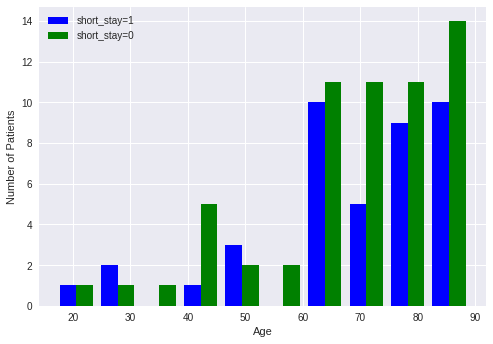

In [20]:
display(training_df.groupby(['short_stay', 'first_stay']).count())

fig, ax = plt.subplots()
shorts = training_df[training_df.short_stay==1].age 
longs = training_df[training_df.short_stay==0].age 
colors = ['b', 'g']
ax.hist([shorts, longs], bins=10, color=colors, label=['short_stay=1', 'short_stay=0'])
ax.set_xlabel('Age')
ax.set_ylabel('Number of Patients')
plt.legend(loc='upper left')
plt.show()

Let's first build a linear regression model to predict the numeric value of "short_stay" based on `age` and `first_stay` features. You can tune the parameters on the right-hand side and observe differences in the evaluation result.

In [21]:
#@title Linear Regression Parameters {display-mode:"both"}
BATCH_SIZE = 5 # @param
NUM_EPOCHS = 100 # @param

first_stay = tf.feature_column.numeric_column('first_stay')
age = tf.feature_column.numeric_column('age')

# Build linear regressor
linear_regressor = tf.estimator.LinearRegressor(feature_columns=[first_stay, age])

# Train the Model.
model = linear_regressor.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x=training_df,
        y=training_df['short_stay'],
        num_epochs=100,
        batch_size=BATCH_SIZE,
        shuffle=True),
    steps=100)

# Evaluate the model.
eval_result = linear_regressor.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x=validation_df,
        y=validation_df['short_stay'],
        batch_size=BATCH_SIZE,
        shuffle=False))

display(eval_result)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f52b74ca950>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpOXDtzf', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpOXDtzf/model.ckpt.
INFO:tensorflow:loss = 1.0, step = 1
INFO:tensorflow:Saving

{'average_loss': 0.23896088, 'global_step': 100, 'loss': 1.0753239}

Remember that the label `short_stay` is actually categorical, with the value 1 for an ICU stay of 1 day or less and value 0 for stays of length 2 days or more. So a classification model better fits this task. Here we try a deep neural networks model using the `DNNClassifier` estimator. Notice the little changes from the regression code above.

In [22]:
#@title ML Training example {display-mode:"both"}
BATCH_SIZE = 5        # @param
NUM_EPOCHS = 100       # @param
HIDDEN_UNITS=[10, 10] # @param

# Build linear regressor
classifier = tf.estimator.DNNClassifier(
    feature_columns=[first_stay, age],
    hidden_units=HIDDEN_UNITS)

# Train the Model.
model = classifier.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x=training_df,
        y=training_df['short_stay'],
        num_epochs=100,
        batch_size=BATCH_SIZE,
        shuffle=True),
    steps=100)

# Evaluate the model.
eval_result = classifier.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x=validation_df,
        y=validation_df['short_stay'],
        batch_size=BATCH_SIZE,
        shuffle=False))

display(eval_result)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f52b2605c10>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpjIbQwt', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpjIbQwt/model.ckpt.
INFO:tensorflow:loss = 17.910744, step = 1
INFO:tensorflow:

{'accuracy': 0.6296296,
 'accuracy_baseline': 0.6296296,
 'auc': 0.44411767,
 'auc_precision_recall': 0.71786493,
 'average_loss': 0.68928003,
 'global_step': 100,
 'label/mean': 0.6296296,
 'loss': 3.1017601,
 'prediction/mean': 0.5083194}

The ANZICS dataset also has some demo tables that you can explore. For example, in the `APD` and `CCR` tables, we can check the number of elements of certain types among the 100 demo records.

In [25]:
run_query('''
SELECT
  hospitalclassification AS Type,
  COUNT(*) AS NumHospitals
FROM anzics_demo.apd
GROUP BY 1
ORDER BY 2 DESC
''')

,Type,NumHospitals
0,Tertiary,43
1,Rural / Regional,23
2,Private,20
3,Metropolitan,14


In [26]:
run_query('''
SELECT
  iculevelname AS ICU_Level,
  COUNT(*) AS NumHospitals,
  SUM(hospitalbeds) AS NumBeds
FROM anzics_demo.ccr
GROUP BY 1
ORDER BY 2 DESC
''')

,ICU_Level,NumHospitals,NumBeds
0,Level 2,38,8190
1,Level 3 / PICU,31,10574
2,Level 1,8,1318


Congratulations! Now you have finished this datathon tutorial, and ready to explore the real data by querying Google BigQuery. To do so, simply remove the `_demo` suffix in the dataset names.
For example, the table `mimic_demo.icustays` becomes `mimic.icustays` when you need the actual MIMIC data. Now, let's do the substitution and, and start the real datathon exploration.

In [23]:
run_query('''
SELECT
  COUNT(*) AS num_rows
FROM
  mimic.icustays
''')

,num_rows
0,61532


In [24]:
run_query('''
SELECT
  subject_id,
  hadm_id,
  icustay_id
FROM
  mimic.icustays
LIMIT 10
''')

,subject_id,hadm_id,icustay_id
0,902,143497,271328
1,2369,145893,252262
2,2902,188351,259381
3,3433,128254,244799
4,3217,167867,287365
5,3952,111515,228117
6,5727,178576,295388
7,6598,128971,224911
8,7163,123117,259041
9,8920,153113,239530


Enjoy!